Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


193/193 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - loss: 0.0033
Epoch 2/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - loss: 7.1296e-04
Epoch 3/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - loss: 4.7426e-04
Epoch 4/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 5.1215e-04
Epoch 5/5
193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - loss: 9.9653e-04
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


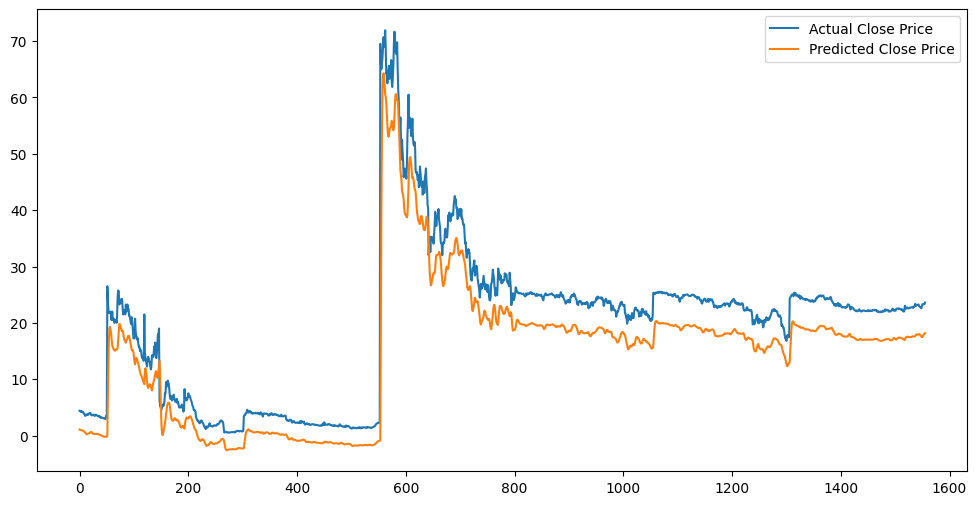

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

# Import MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Initialize Spark Session
spark = SparkSession.builder.appName("StockPrediction").getOrCreate()

# Load dataset
file_path = "infolimpioavanzadoTarget.csv"  # Update the path if needed
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Convert to Pandas DataFrame for processing
df_pd = df.toPandas()

# Extract 'close' prices for prediction
data = df_pd[['close']].values

# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Function to create time-series dataset
def create_dataset(data, time_step):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        x.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(x), np.array(y)

# Define time step
time_step = 60

# Split data into train and test sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size - time_step:]

x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshape input for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)

# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Rescale y_test for comparison
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Close Price')
plt.plot(predictions, label='Predicted Close Price')
plt.legend()
plt.show()

# Stop Spark Session
spark.stop()


In [ ]:
'''Sure! Here's a **line-by-line explanation**, **theoretical background**, and **possible viva/external questions** for your **Stock Price Prediction using LSTM and PySpark** project:

---

## ✅ Code Explanation with Theory:

### 📦 Import Libraries
```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
```
- **Why**: These libraries are used for:
  - **NumPy, Pandas**: Data handling
  - **Matplotlib**: Visualization
  - **PySpark**: Scalable data processing
  - **Scikit-learn**: Scaling data
  - **Keras (TensorFlow)**: Deep learning model building with LSTM layers

---

### 🚀 Initialize Spark
```python
spark = SparkSession.builder.appName("StockPrediction").getOrCreate()
```
- **SparkSession** initializes a PySpark environment to work with large datasets efficiently.

---

### 📁 Load Dataset
```python
file_path = "/content/infolimpioavanzadoTarget.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
```
- **Reads** the stock CSV into a Spark DataFrame.
- `inferSchema=True` automatically detects column data types.

---

### 🔄 Convert to Pandas
```python
df_pd = df.toPandas()
```
- Converts Spark DataFrame to Pandas for easier preprocessing and ML model compatibility.

---

### 🎯 Extract 'close' Price
```python
data = df_pd[['close']].values
```
- **Stock price prediction** focuses on the ‘close’ price (last traded price of the day).

---

### 🔍 Normalize Data
```python
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
```
- **MinMaxScaler** scales data between 0 and 1 to make training faster and more stable.

---

### ⏳ Create Dataset with Time Steps
```python
def create_dataset(data, time_step):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        x.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(x), np.array(y)
```
- Converts sequential data into supervised learning format.
- **Time step** = number of previous data points to predict the next.

---

### 🧪 Train-Test Split
```python
time_step = 60
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size - time_step:]
```
- **80-20 split** between training and testing.
- The test set includes a `time_step` overlap to maintain sequence continuity.

---

### 📐 Format for LSTM
```python
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
```
- **LSTM input shape**: (samples, time steps, features) → required for sequence modeling.

---

### 🧠 Build LSTM Model
```python
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])
```
- **Sequential**: Stack layers one after another.
- **LSTM layers**: Learn long-term dependencies in sequences.
- **Dense**: Fully connected layers to output the final prediction.

---

### 🛠 Compile and Train
```python
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)
```
- **Optimizer**: Adam for adaptive learning rate.
- **Loss**: MSE (Mean Squared Error) for regression.
- **Training** for 5 epochs with batch size of 32.

---

### 🔮 Predict and Inverse Transform
```python
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
```
- Predicts future prices and converts them back to original scale using inverse transform.

---

### 📊 Plot Results
```python
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Close Price')
plt.plot(predictions, label='Predicted Close Price')
plt.legend()
plt.show()
```
- Visualizes actual vs predicted stock prices.

---

### 🛑 Stop Spark
```python
spark.stop()
```
- Cleanly ends the Spark session.

---

## 💡 Theory Involved

- **Time-Series Forecasting**: Predicting future values based on past data.
- **LSTM (Long Short-Term Memory)**:
  - Type of RNN (Recurrent Neural Network)
  - Good at learning long-term dependencies in sequences.
- **MinMax Scaling**: Normalizes data to improve learning.
- **Train-Test Split**: Avoids overfitting and helps model generalize.
- **Mean Squared Error (MSE)**: Measures average squared difference between actual and predicted values.

---

## 🎓 Possible Viva Questions

Absolutely! Here's a comprehensive **list of potential viva/external examiner questions** with **clear, concise answers** related to your **Stock Price Prediction using LSTM and PySpark** project:

---

### 🔢 **General Conceptual Questions**

**1. What is LSTM and why is it used here?**
**Answer:**
LSTM (Long Short-Term Memory) is a type of Recurrent Neural Network (RNN) designed to learn long-term dependencies in sequence data. It is used here because stock prices are time-series data, and LSTMs are effective at capturing trends and patterns over time.

---

**2. What is time-series forecasting?**
**Answer:**
Time-series forecasting involves predicting future values based on previously observed values. It is useful in fields like finance, weather forecasting, and inventory management.

---

**3. Why do we normalize the data using MinMaxScaler?**
**Answer:**
Normalization helps scale data to a standard range (typically 0 to 1). This improves convergence during training, ensures that no feature dominates, and stabilizes the learning process.

---

**4. What is the role of the time step in your model?**
**Answer:**
The time step defines how many previous data points are used to predict the next one. In this project, we use the last 60 values (time_step=60) to predict the next closing price.

---

**5. Why do we reshape the input before passing it to the LSTM?**
**Answer:**
LSTM expects input in the format `(samples, time steps, features)`. Reshaping ensures the data fits this required input shape for sequential learning.

---

**6. Why did you choose the 'close' price for prediction?**
**Answer:**
The 'close' price is widely used in financial modeling because it represents the final value of a stock for the trading day and reflects market sentiment.

---

**7. What is the difference between return_sequences=True and False in LSTM?**
**Answer:**
- `return_sequences=True`: Outputs the full sequence of hidden states.
- `return_sequences=False`: Outputs only the last hidden state.
In the first LSTM layer we return sequences to feed into the second LSTM. In the last LSTM, we set it to False to output a single value.

---

### 📈 **Data and Model Questions**

**8. What does MinMaxScaler do?**
**Answer:**
It scales each feature to a fixed range, usually [0, 1]. It’s important for neural networks to ensure uniform learning across all inputs.

---

**9. Why do we split the data into training and testing sets?**
**Answer:**
To evaluate the model's performance on unseen data and ensure it generalizes well without overfitting.

---

**10. What is Mean Squared Error (MSE), and why do you use it?**
**Answer:**
MSE is the average of squared differences between predicted and actual values. It penalizes larger errors more, making it ideal for regression problems like this.

---

**11. What does the Dense layer do in your model?**
**Answer:**
Dense layers are fully connected layers used to interpret features extracted by the LSTM layers and produce the final output, which is a single predicted value in this case.

---

**12. Why use two LSTM layers instead of one?**
**Answer:**
Stacking LSTM layers can allow the model to learn more complex patterns and hierarchical temporal features, potentially improving prediction accuracy.

---

### 🔮 **Prediction and Evaluation**

**13. Why do you use `inverse_transform()` after prediction?**
**Answer:**
Since we scaled the data before training, predictions are in scaled form. `inverse_transform()` converts them back to original scale (actual stock price) for interpretation and visualization.

---

**14. How would you evaluate the performance of your model?**
**Answer:**
By calculating metrics like RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and visually comparing actual vs predicted values using plots.

---

**15. What are the limitations of LSTM in stock prediction?**
**Answer:**
- LSTMs assume that future trends are based on past data only.
- Stock prices are affected by unpredictable events like news or politics.
- LSTM may overfit if not carefully tuned.

---

**16. Can you improve this model further?**
**Answer:**
Yes, by:
- Adding more features (volume, open, high/low, technical indicators)
- Increasing epochs or tuning hyperparameters
- Using Bidirectional LSTM or attention mechanisms
- Applying dropout layers to avoid overfitting

---

**17. Why did you use PySpark if you converted data to Pandas later?**
**Answer:**
PySpark is useful for handling large datasets. Even if we convert to Pandas for modeling, PySpark is beneficial during data ingestion, cleaning, and transformation when working at scale.

---

**18. What is the role of batch_size and epochs in training?**
**Answer:**
- `batch_size` determines how many samples are processed before updating the model.
- `epochs` define how many times the entire dataset is passed through the model.

'''